# Are Rosetta's range rate residuals explained by tracking signal lag?

Range rate residual oscillations similar to those of NEAR's post-encounter Doppler were reported for Rosetta's 2005 Earth flyby, which also had an anomalous $\Delta v$ [2].

They are similarly reproduced below by simulation of light-time lags in the tracking signal. They incidentally vanish if the initial state for the orbital elements is taken 3 or more days before perigee, as the initial lag is then too small to inflict a significant change at and through the perigee.


In [1]:
from astropy import units as u
#sampling_interval = 10*u.minute
sampling_interval = 1*u.hour
min_elevation = -30*u.deg
skip_hidden = True

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss24, esNewNorcia
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)

def fitv(ref_orbit, stations, elev, epochs, sim_meas, title, _trace=False):

    residual = {}
    fitter = {}
    for st in stations:
        fitter[st] = OrbitFitter(ref_orbit, [st], trace=_trace)
        fitter[st].fit_doppler_data(epochs, sim_meas[st])
        print(fitter[st].report())
        print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter[st].runtime))
        describe_orbit(fitter[st].orbit)

        el = elev[st]
        res = fitter[st].result.residual
        residual[st] = res * [1.0 if v >= min_elevation else np.nan
                              for v in el]

    plots(epochs, residual, title, 'range rate (m/s)')
    return residual

In [3]:
solar_system_ephemeris.set("de440")
tracking_stations = ( esNewNorcia, dss24 )

rosetta_start = Tracking.ROSETTA05_PERIGEE.value - 5*u.day
rosetta_end = Tracking.ROSETTA05_PERIGEE.value + 4*u.day

epochs = make_epochs(rosetta_start, rosetta_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

Start and end: 2005-02-27 22:09:14.000 2005-03-08 21:09:14.000 [ 216 ]


In [4]:
rosetta_ref_orbit = orbit_from_horizons("Rosetta", rosetta_start)
describe_orbit(rosetta_ref_orbit)

rosetta_ref_ephem = rosetta_ref_orbit.to_ephem(EpochsArray(epochs))


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.58664600578908 deg
Eccentricity: 1.221189932761136
Semilatus rectum: 12977.252613985196 km
Semimajor axix: -26413.849902769125 km
Periapse radius: 5842.477683956241 km , altitude: -535.6589160437588 km


In [5]:
scalefactor = 0.1
elev = {}

vdata_ref = {}
vlags = {}
vlags_full = {}
vdata_constvlags = {}
vdata_ltlags_full = {}
vdata_ltlags = {}
vdata_scaledlags = {}

for st in tracking_stations:

    vdata_ref[st] = []
    vlags[st] = []
    vlags_full[st] = []
    vdata_constvlags[st] = []
    vdata_ltlags_full[st] = []
    vdata_ltlags[st] = []
    vdata_scaledlags[st] = []

    elev[st] = []

    first_vlag = None

    for e in epochs[:-1]:
        ref_r, ref_rr, ref_ra, ref_rs, ref_elev = st.range_rate_accel_elev(rosetta_ref_ephem, e)
        #print(e.strftime("%H:%M:%S"),
        #     ref_r.to_value(u.km),
        #     ref_ra.to_value(u.m/(u.s*u.s)),
        #     ref_rs.to_value(u.m/(u.s*u.s)),
        #     (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
        #     )

        #print(e, st.name, ref_elev << u.deg)
        elev[st].append(ref_elev)
        if skip_hidden and ref_elev < min_elevation:
            vlags[st].append(np.nan)
            vlags_full[st].append(np.nan)

            vdata_ref[st].append([np.nan])
            vdata_constvlags[st].append([np.nan])
            vdata_ltlags_full[st].append([np.nan])
            vdata_ltlags[st].append([np.nan])
            vdata_scaledlags[st].append([np.nan])

            continue

        vlag_full = ref_ra*ref_r/const.c
        vlag = (ref_ra+ref_rs)*ref_r/const.c

        if first_vlag is None:
            first_vlag = vlag

        vlags[st].append(vlag)
        vlags_full[st].append(vlag_full)

        vdata_ref[st].append([ref_rr])
        vdata_constvlags[st].append([ref_rr - first_vlag])
        vdata_ltlags_full[st].append([ref_rr - vlag_full])
        vdata_ltlags[st].append([ref_rr - vlag])
        vdata_scaledlags[st].append([ref_rr - scalefactor*vlag])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 215
    # variables        = 6
    chi-square         = 5.2667e-09
    reduced chi-square = 2.5199e-11
    Akaike info crit   = -5240.98822
    Bayesian info crit = -5220.76440
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -26413849.9 (init = -2.641385e+07)
    ecc:   1.22118993 (init = 1.22119)
    inc:   2.52351303 (init = 2.523513)
    nu:   -2.51985175 (init = -2.519852)
    raan:  2.96847181 (init = 2.968472)
    argp:  2.59238761 (init = 2.592388)
Time elapsed (hh:mm:ss.ms) 0:00:06.639389

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.58664600578908 deg
Eccentricity: 1.221189932761136
Semilatus rectum: 12977252.613985198 m
Semimajor axix: -26413849.902769126 m
Periapse radius

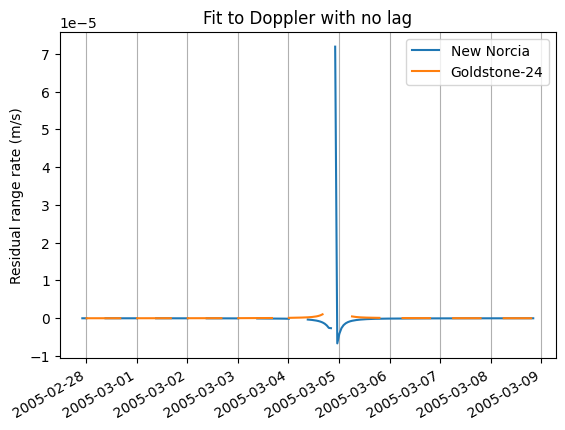

In [6]:
base_residual = fitv(rosetta_ref_orbit, tracking_stations, elev, epochs[:-1], vdata_ref, "Fit to Doppler with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 215
    # variables        = 6
    chi-square         = 9.3292e-05
    reduced chi-square = 4.4637e-07
    Akaike info crit   = -3137.83922
    Bayesian info crit = -3117.61539
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -26413849.9 (init = -2.641385e+07)
    ecc:   1.22118993 (init = 1.22119)
    inc:   2.52351303 (init = 2.523513)
    nu:   -2.51985175 (init = -2.519852)
    raan:  2.96847181 (init = 2.968472)
    argp:  2.59238761 (init = 2.592388)
Time elapsed (hh:mm:ss.ms) 0:00:06.536057

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.58664600578908 deg
Eccentricity: 1.221189932761136
Semilatus rectum: 12977252.613985198 m
Semimajor axix: -26413849.902769126 m
Periapse radius

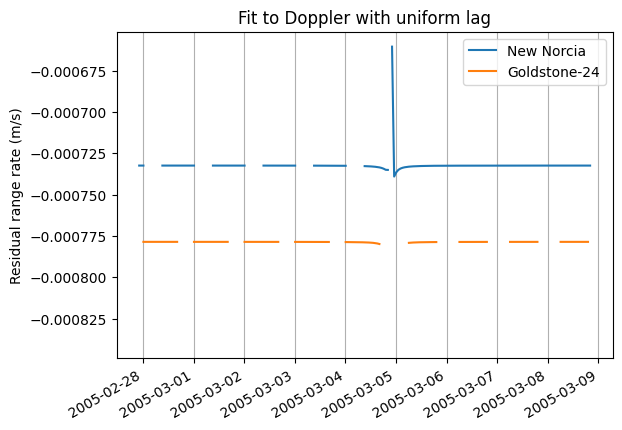

In [7]:
const_residual = fitv(rosetta_ref_orbit, tracking_stations, elev, epochs[:-1], vdata_constvlags, "Fit to Doppler with uniform lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 215
    # variables        = 6
    chi-square         = 0.01339070
    reduced chi-square = 6.4070e-05
    Akaike info crit   = -2070.02405
    Bayesian info crit = -2049.80023
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -26413849.9 (init = -2.641385e+07)
    ecc:   1.22118993 (init = 1.22119)
    inc:   2.52351303 (init = 2.523513)
    nu:   -2.51985175 (init = -2.519852)
    raan:  2.96847181 (init = 2.968472)
    argp:  2.59238761 (init = 2.592388)
Time elapsed (hh:mm:ss.ms) 0:00:06.583853

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.58664600578908 deg
Eccentricity: 1.221189932761136
Semilatus rectum: 12977252.613985198 m
Semimajor axix: -26413849.902769126 m
Periapse radius

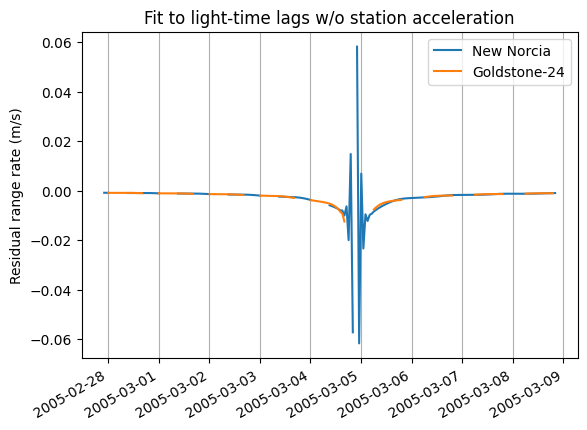

In [8]:
lt_residual = fitv(rosetta_ref_orbit, tracking_stations, elev, epochs[:-1], vdata_ltlags, "Fit to light-time lags w/o station acceleration")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 215
    # variables        = 6
    chi-square         = 0.50554156
    reduced chi-square = 0.00241886
    Akaike info crit   = -1289.34406
    Bayesian info crit = -1269.12023
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -26413849.9 (init = -2.641385e+07)
    ecc:   1.22118993 (init = 1.22119)
    inc:   2.52351303 (init = 2.523513)
    nu:   -2.51985175 (init = -2.519852)
    raan:  2.96847181 (init = 2.968472)
    argp:  2.59238761 (init = 2.592388)
Time elapsed (hh:mm:ss.ms) 0:00:06.601739

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 144.58664600578908 deg
Eccentricity: 1.221189932761136
Semilatus rectum: 12977252.613985198 m
Semimajor axix: -26413849.902769126 m
Periapse radius

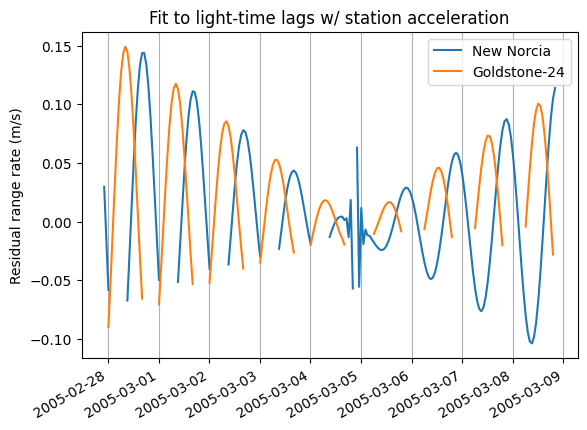

In [9]:
full_residual = fitv(rosetta_ref_orbit, tracking_stations, elev, epochs[:-1], vdata_ltlags_full, "Fit to light-time lags w/ station acceleration")

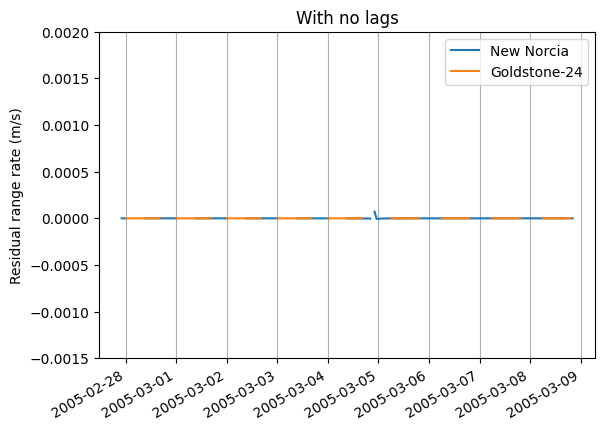

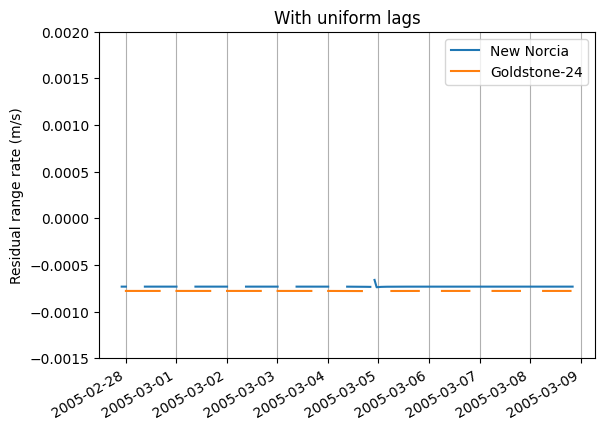

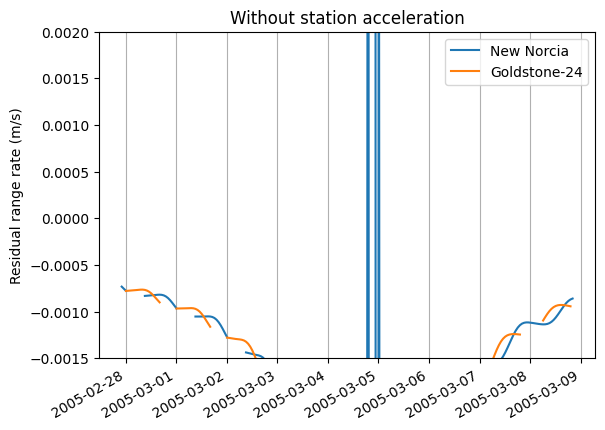

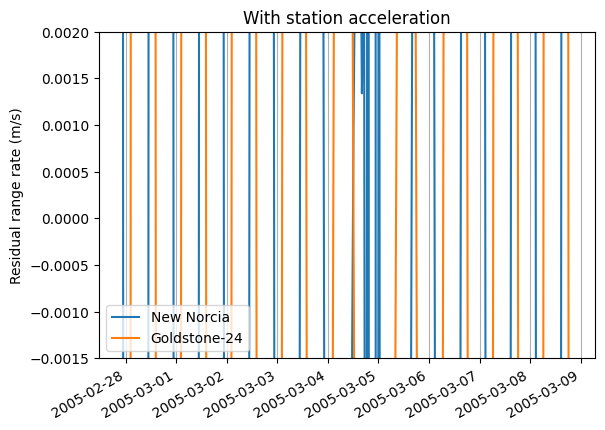

In [10]:
# Summary plots
ylim = [-1.5e-3, 2.0e-3]

plot_residual(epochs[:-1], base_residual, 'With no lags', 'Residual range rate (m/s)', ylim)
plot_residual(epochs[:-1], const_residual, 'With uniform lags', 'Residual range rate (m/s)', ylim)
plot_residual(epochs[:-1], lt_residual, 'Without station acceleration', 'Residual range rate (m/s)', ylim)
plot_residual(epochs[:-1], full_residual, 'With station acceleration', 'Residual range rate (m/s)', ylim)
